In [1]:
# Force garbage collection
import gc
gc.collect()

41

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import precision_recall_curve, auc

In [4]:
import pickle
# %pip install shap --upgrade
import shap

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("SHAP version")
    print(shap.__version__)


check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
SHAP version
0.47.1


In [6]:
# season_map = {'summer': [5,6,7,8], 
#                   'winter': [10,11,12,1,2,3]}

# wind_direction_range_map = {'north': [315, 90],
#                             'south': [360, 100]}

In [6]:
def data_prep(data, eval_year=2007, area='all', 
              season='all',
              wind_speed_threshold=0, 
              wind_speed_region="not filtered",
              fire_size_threshold=0,
              if_filter_wind_direction=False,
              wind_direction_range=[0, 360],
              month_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              fire_event_only=True):
    # Initialize a list to store log messages
    log_messages = []

    # Log the parameters
    log_messages.append(f"Parameters: eval_year={eval_year}, area={area}, season={season}, "
                        f"wind_speed_threshold={wind_speed_threshold}, wind_speed_region={wind_speed_region}, "
                        f"fire_size_threshold={fire_size_threshold}, if_filter_wind_direction={if_filter_wind_direction}, "
                        f"wind_direction_range={wind_direction_range}, month_list={month_list}, "
                        f"fire_event_only={fire_event_only}")

    # Check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        log_messages.append('Year column is added')

    # Check if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        log_messages.append('Month column is added')
    
    if season == 'all':
        log_messages.append('No season split')
    else:
        month_list = season_map[season] if season in season_map else month_list

    # Filter data to be in month_list
    data = data[data['Month'].isin(month_list)]
    log_messages.append(f"The unique values of month are: {data['Month'].unique()}")

    # add log messages for range of day
    log_messages.append(f"The min and max day are: {data['day'].min()}, {data['day'].max()}")

    data = data[data['SubRegion'] == area] if area != 'All' else data
    log_messages.append(f"The unique values of SubRegion are: {data['SubRegion'].unique()}")

    # Filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    else:
        log_messages.append('The wind speed is not filtered')
    
    if if_filter_wind_direction:
        log_messages.append('The wind direction is filtered')
        wind_direction_min, wind_direction_max = wind_direction_range
        if wind_direction_min < wind_direction_max:
            # Filter the data to be between wind_direction_min and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
        else: 
            # Filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | 
                        (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    if fire_size_threshold > 0:
        # Filter the data to be greater than fire_size_threshold
        log_messages.append('The fire size is filtered')
        data = data[data['min_FIRE_SIZE'] > fire_size_threshold]
        log_messages.append(f"The min and max fire size are: {data['min_FIRE_SIZE'].min()}, {data['min_FIRE_SIZE'].max()}")
    else:
        log_messages.append('The fire size is not filtered')

    if fire_event_only:
        # Filter the data to be fire event only
        log_messages.append('The fire event is filtered')
        data = data[data['IS_FIRE'] == 1]
        
    log_messages.append(f"The shape of data is: {data.shape}")
    #log_messages.append(f"The sum of IS_FIRE is: {data['IS_FIRE'].sum()}")
    #log_messages.append(f"The mean of IS_FIRE is: {data['IS_FIRE'].mean()}")   

    # Return the filtered data and the log messages, and the sum of IS_FIRE
    return data, "\n".join(log_messages), data['IS_FIRE'].sum()

In [7]:
def plot_feature_importance(model, output_path = "../Plot/FeatureImportance/", title='Feature Importance', max_num_features=10, show=False, eval_year=2007):
    """
    Plot the feature importance of a trained model and save the plot.

    Parameters:
        model (xgboost.Booster): Trained XGBoost model.
        output_path (str): Path to save the plot (e.g., 'path/to/plot.png').
        title (str): Title of the plot.
        max_num_features (int): Maximum number of features to display in the plot.

    Returns:
        None
    """
    # Get feature importance scores
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort features by importance
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Create a DataFrame for plotting
    df_importance = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
    
    # Limit to max_num_features
    df_importance = df_importance.head(max_num_features)
    # from eval_year, get training year,which is eval_year - 6 to eval_year - 1
    training_start_year = eval_year - 6
    training_end_year = eval_year - 1

    # Plotting
    plt.figure(figsize=(10, min(6 + 0.1 * max_num_features, 20)))  # Limits max heigh
    plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'{title} ({training_start_year}-{training_end_year})')
    plt.grid(axis='x')

    plt.gca().invert_yaxis()

    if show:
        plt.show()
    else:
        # Save the plot to the specified output path
        plt.savefig(os.path.join(output_path, f'{eval_year}_FI.png'), bbox_inches='tight')
        plt.close()

In [11]:
def plot_shap_bar(Eval_data, features, explainer, save_path = '../', show=False, save = False, top_n=15):
    """
    Computes SHAP values, calculates correlations, and generates a bar plot.
    
    Parameters:
    - Eval_data: DataFrame containing feature values
    - features: List of feature names
    - save_path: Path to save the generated plot
    
    Saves:
    - A bar plot displaying the top 15 features based on SHAP values
    """
    # Compute SHAP values
    shap_values = explainer(Eval_data[features])
    
    # Convert SHAP values into a DataFrame
    shap_df = pd.DataFrame(shap_values.values, columns=features)

    # Select top 15 features based on mean absolute SHAP values
    top_features_shap = shap_df.abs().mean().nlargest(top_n)
    top_features = top_features_shap.index

    # Filter SHAP and feature values for selected top features
    shap_df = shap_df[top_features].reset_index(drop=True)
    feature_values = Eval_data[top_features].reset_index(drop=True)

    # Compute Pearson correlation coefficient between SHAP values and feature values
    correlation_coeffs = shap_df.corrwith(feature_values, numeric_only=False)

    # Sort features for better visualization
    top_features_shap = top_features_shap.loc[correlation_coeffs.index].sort_values()

    # Assign colors: dark green for positive correlation, red for negative correlation
    colors = ['darkgreen' if correlation_coeffs[feature] > 0 else 'red' for feature in top_features_shap.index]

    # Plot the bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(top_features_shap.index, top_features_shap.values, color=colors)
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Features")
    plt.title("Top 15 Features based on SHAP Values")

    if show:
        plt.show()        
    if save:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.close()

    shap_df_return = pd.DataFrame({
        'mean_abs_shap': top_features_shap,
        'corr': correlation_coeffs[top_features_shap.index]
    })

    # return the data for plot
    return shap_df_return

In [12]:
# top 25

years = range(2001, 2021)

SubRegions = [
 'All',
 'North Coast',
 'Central Coast',
 'North Interior',
 'Sierra Nevada',
 'South Coast']

# Calculate the total number of iterations
total_iterations = len(years) * len(SubRegions)

big_fire_size = 0
# surpress warnings
warnings.filterwarnings("ignore")


model_version = "Extended_Data_Water_Year_no_riparian_desert_wetland_barren_group_veg"
input_path = f'../../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{model_version}/parquet'
model_path = f'../../Model/{model_version}'

all_shap_values = []  # NEW: to collect SHAP value info

with tqdm(total=total_iterations, desc="Processing years, areas") as pbar:

    for yr in years:
        # load parquet data
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
       
        # Load the model
        with open(f'{model_path}/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)

        features = loaded_model.get_booster().feature_names

        explainer = shap.Explainer(loaded_model)

        for area in SubRegions:
            # add separate log messages for each iteration
            Eval_region_season, _, fire_num = data_prep(Eval_data, eval_year=yr, area=area, season="all", fire_size_threshold = big_fire_size)
            top_features_shap = plot_shap_bar(Eval_region_season, features, explainer, '../', show=False, save=False, top_n=25)

            # NEW: Save SHAP value info with metadata
            # Add year, area, season columns
            top_features_shap['year'] = yr
            top_features_shap['area'] = area
            
            # Collect results
            all_shap_values.append(top_features_shap)

            gc.collect()  # Force garbage collection to free up memory
            # Update the progress bar after each iteration
            pbar.update(1)

        # clean up the memory
        del Eval_data

Processing years, areas: 100%|██████████| 120/120 [04:11<00:00,  2.09s/it]


In [14]:
path_to_save

'../../Summary_Data/Shap_Value/Extended_Data_Water_Year_no_riparian_desert_wetland_barren_group_veg/'

In [13]:
path_to_save = f'../../Summary_Data/Shap_Value/{model_version}/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

all_shap_values_df = pd.concat(all_shap_values, ignore_index=False)
all_shap_values_df = all_shap_values_df.reset_index().rename(columns={'index': 'feature'})

all_shap_values_df.to_csv(f'{path_to_save}/shap_values_top_25.csv', index=False)

In [10]:
# non - season split

years = range(2001, 2021)

SubRegions = [
 'All',
 'North Coast',
 'Central Coast',
 'North Interior',
 'Sierra Nevada',
 'South Coast']

# Calculate the total number of iterations
total_iterations = len(years) * len(SubRegions)

big_fire_size = 0
# surpress warnings
warnings.filterwarnings("ignore")

log_messages = []
# log current date and time
log_messages.append(f"Current date and time: {pd.Timestamp.now()}")
# append season map
log_messages.append(f"Season: No Split")

model_version = "Extended_Data_Water_Year_no_riparian_desert_wetland_barren_group_veg"
input_path = f'../../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{model_version}/parquet'
model_path = f'../../Model/{model_version}'

# feature_importance_plot_pathall = '../Plot/water_year_filter_veg_original_road_population_density/FeatureImportance/ALL/'
# feature_importance_plot_pathtop = '../Plot/water_year_filter_veg_original_road_population_density/FeatureImportance/TOP25/'
shap_plot_path_root = f'../../Plot/{model_version}/Shap/AllFireAllSeason/Mean_Abs_SHAP_Bar/'

# if not os.path.exists(feature_importance_plot_pathall):
#     os.makedirs(feature_importance_plot_pathall)
# if not os.path.exists(feature_importance_plot_pathtop):
#     os.makedirs(feature_importance_plot_pathtop)
if not os.path.exists(shap_plot_path_root):
    os.makedirs(shap_plot_path_root)

all_importances = []
all_shap_values = []  # NEW: to collect SHAP value info
all_fire_nums = []  # NEW: to collect fire_num info

with tqdm(total=total_iterations, desc="Processing years, areas") as pbar:
    # log sep line
    log_messages.append("-" * 50)
    for yr in years:
        # load parquet data
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
       
        # Load the model
        with open(f'{model_path}/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)

        features = loaded_model.get_booster().feature_names
        xgb_importance_dict = loaded_model.get_booster().get_score(importance_type='gain')
        xgb_importance = np.array([xgb_importance_dict.get(f, 0.0) for f in features])
        xgb_importance_percent = 100 * xgb_importance / xgb_importance.sum()
        # Create a DataFrame for this year
        xgb_df = pd.DataFrame({
            'feature': features,
            'year': yr,
            'relative_importance': xgb_importance_percent
        })
        all_importances.append(xgb_df)


        explainer = shap.Explainer(loaded_model)

        for area in SubRegions:
            # add separate log messages for each iteration
            log_messages.append(f"Processing year: {yr}, region: {area}")
            # Load the data
            Eval_region_season, log, fire_num = data_prep(Eval_data, eval_year=yr, area=area, season="all", fire_size_threshold = big_fire_size)
            all_fire_nums.append({
                'year': yr,
                'area': area,
                'fire_num': fire_num
            })
            # append the log messages to the main log
            log_messages.append(log)      

            shap_plot_path = f'{shap_plot_path_root}/SHAP_Bar_{yr}_{area}_greater_{big_fire_size}.png'
            top_features_shap = plot_shap_bar(Eval_region_season, features, explainer, shap_plot_path, show=False)

            # NEW: Save SHAP value info with metadata
            # Add year, area, season columns
            top_features_shap['year'] = yr
            top_features_shap['area'] = area
            
            # Collect results
            all_shap_values.append(top_features_shap)

            gc.collect()  # Force garbage collection to free up memory
            # Update the progress bar after each iteration
            pbar.update(1)

        # clean up the memory
        del Eval_data

Processing years, areas: 100%|██████████| 120/120 [04:40<00:00,  2.34s/it]


In [9]:
years = range(2001, 2021)

# season_map = {'summer': [5,6,7,8,9], 
#                   'winter': [10,11,12,1]}

season_map = {'summer': [6,7,8], 
                  'winter': [10,11,12]}

SubRegions = [
 'North Coast',
 'Central Coast',
 'North Interior',
 'Sierra Nevada',
 'South Coast']

# Calculate the total number of iterations
total_iterations = len(years) * len(SubRegions) * 2

big_fire_size = 0
# surpress warnings
warnings.filterwarnings("ignore")

log_messages = []
# log current date and time
log_messages.append(f"Current date and time: {pd.Timestamp.now()}")
# append season map
log_messages.append(f"Season map: {season_map}")

model_version = "Extended_Data_Water_Year_no_riparian_remove_veg"
input_path = f'../../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{model_version}/parquet'
model_path = f'../../Model/{model_version}'

# feature_importance_plot_pathall = '../Plot/water_year_filter_veg_original_road_population_density/FeatureImportance/ALL/'
# feature_importance_plot_pathtop = '../Plot/water_year_filter_veg_original_road_population_density/FeatureImportance/TOP25/'
shap_plot_path_root = f'../../Plot/{model_version}/Shap/AllFire/Mean_Abs_SHAP_Bar/'

# if not os.path.exists(feature_importance_plot_pathall):
#     os.makedirs(feature_importance_plot_pathall)
# if not os.path.exists(feature_importance_plot_pathtop):
#     os.makedirs(feature_importance_plot_pathtop)
if not os.path.exists(shap_plot_path_root):
    os.makedirs(shap_plot_path_root)

all_importances = []
all_shap_values = []  # NEW: to collect SHAP value info
all_fire_nums = []  # NEW: to collect fire_num info

with tqdm(total=total_iterations, desc="Processing years, areas, and season") as pbar:
    # log sep line
    log_messages.append("-" * 50)
    for yr in years:
        # load parquet data
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
       
        # Load the model
        with open(f'{model_path}/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)

        features = loaded_model.get_booster().feature_names
        xgb_importance_dict = loaded_model.get_booster().get_score(importance_type='gain')
        xgb_importance = np.array([xgb_importance_dict.get(f, 0.0) for f in features])
        xgb_importance_percent = 100 * xgb_importance / xgb_importance.sum()
        # Create a DataFrame for this year
        xgb_df = pd.DataFrame({
            'feature': features,
            'year': yr,
            'relative_importance': xgb_importance_percent
        })
        all_importances.append(xgb_df)


        explainer = shap.Explainer(loaded_model)

        for area in SubRegions:
            for season in ['summer', 'winter']:
                # add separate log messages for each iteration
                log_messages.append(f"Processing year: {yr}, region: {area}, season: {season}")
                # Load the data
                Eval_region_season, log, fire_num = data_prep(Eval_data, eval_year=yr, area=area, season=season, fire_size_threshold = big_fire_size)
                # NEW: Collect fire_num with metadata
                all_fire_nums.append({
                    'year': yr,
                    'area': area,
                    'season': season,
                    'fire_num': fire_num
                })
                # append the log messages to the main log
                log_messages.append(log)      

                shap_plot_path = f'{shap_plot_path_root}/SHAP_Bar_{yr}_{area}_{season}_greater_{big_fire_size}.png'
                top_features_shap = plot_shap_bar(Eval_region_season, features, explainer, shap_plot_path, show=False)

                # NEW: Save SHAP value info with metadata
                # Add year, area, season columns
                top_features_shap['year'] = yr
                top_features_shap['area'] = area
                top_features_shap['season'] = season
            
                # Collect results
                all_shap_values.append(top_features_shap)

                gc.collect()  # Force garbage collection to free up memory
                # Update the progress bar after each iteration
                pbar.update(1)

        # clean up the memory
        del Eval_data

Processing years, areas, and season:   0%|          | 0/200 [00:00<?, ?it/s]

Processing years, areas, and season: 100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


In [11]:
# Save the log messages to a log file
with open('../../Logs/Clean_Extended_Data/plot_shap_by_subregion_wateryear_no_4.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))

In [12]:
fire_num_df = pd.DataFrame(all_fire_nums)

In [13]:
feature_importance_all_years = pd.concat(all_importances, ignore_index=True)

In [14]:
all_shap_values_df = pd.concat(all_shap_values, ignore_index=False)
all_shap_values_df = all_shap_values_df.reset_index().rename(columns={'index': 'feature'})

In [15]:
feature_importance_all_years.shape, fire_num_df.shape,all_shap_values_df.shape

((580, 3), (120, 3), (1800, 5))

In [16]:
# check the sum of relative_importance group by year
feature_importance_all_years.groupby('year')['relative_importance'].sum()

year
2001    100.0
2002    100.0
2003    100.0
2004    100.0
2005    100.0
2006    100.0
2007    100.0
2008    100.0
2009    100.0
2010    100.0
2011    100.0
2012    100.0
2013    100.0
2014    100.0
2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
2020    100.0
Name: relative_importance, dtype: float64

In [17]:
path_to_save = f'../../Summary_Data/Feature_Importance/{model_version}/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

feature_importance_all_years.to_csv(f'{path_to_save}/feature_importance_all_years.csv', index=False)

In [18]:
path_to_save = f'../../Summary_Data/Shap_Value/{model_version}/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

all_shap_values_df.to_csv(f'{path_to_save}/shap_values_top_15.csv', index=False)
fire_num_df.to_csv(f'{path_to_save}/fire_num_by_year_area_season.csv', index=False)

In [19]:
# for each year, only keep the top 10 features
top_features = feature_importance_all_years.groupby('year').apply(lambda x: x.nlargest(10, 'relative_importance')).reset_index(drop=True)
top_features.shape # 10 features * 20 years

(200, 3)

In [20]:
top_features.head()

,feature,year,relative_importance
0,max_air_temperature,2001,22.519954
1,road_density_km_km2,2001,10.168918
2,line_density_km_per_cell,2001,4.213952
3,dead_fuel_moisture_1000hr,2001,4.160884
4,SWE,2001,4.016591


In [21]:
feature_importance_plot_pathtop = f'../../Plot/{model_version}/FeatureImportance/TOP10FromEachYear/'
if not os.path.exists(feature_importance_plot_pathtop):
    os.makedirs(feature_importance_plot_pathtop)

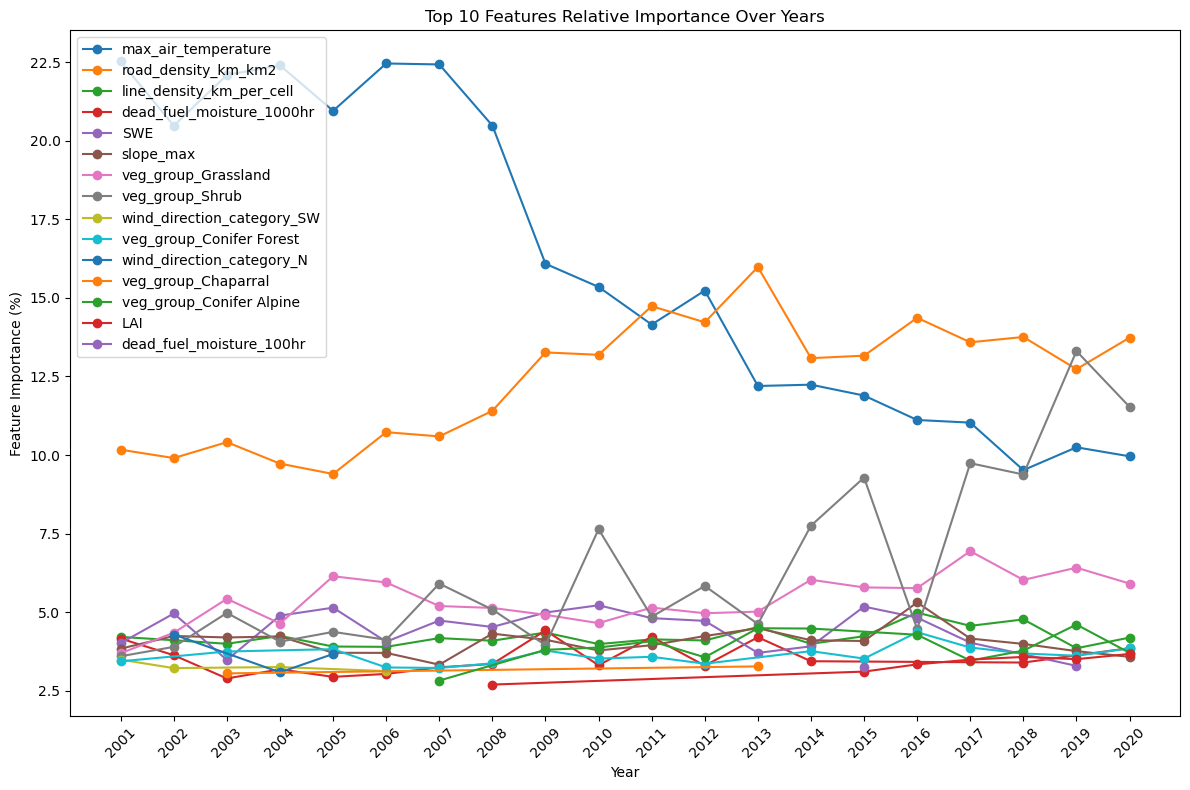

In [22]:
# plot, x axis is year, y axis is relative importance, color is feature
plt.figure(figsize=(12, 8))
for feature in top_features['feature'].unique():
    feature_data = top_features[top_features['feature'] == feature]
    plt.plot(feature_data['year'], feature_data['relative_importance'], marker='o', label=feature)
plt.title('Top 10 Features Relative Importance Over Years')
plt.xlabel('Year')
plt.ylabel('Feature Importance (%)')
years = sorted(top_features['year'].unique())
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f'{feature_importance_plot_pathtop}top_10_features_importance_pct_over_years.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

ROC Plots in One

In [23]:
gc.collect()

526613

In [24]:
model_version

'Extended_Data_Water_Year_no_riparian_desert_wetland_barren_group_veg'

In [25]:
# Setup
fpr_points = np.linspace(0, 1, 100)
recall_points = np.linspace(0, 1, 100)

tprs = []
aucs = []
precisions = []
aps = []

all_y_true = []

years = range(2001, 2021)

model_version = "Extended_Data_Water_Year_no_riparian_desert_wetland_barren_group_veg"
input_path = f'../../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{model_version}/parquet'

with tqdm(total=len(years), desc="Processing years, areas, and season") as pbar:
    for yr in years:
        # Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year/{yr}_predictions.csv')
        # read the parquet file
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
        y_true = Eval_data['IS_FIRE']
        y_score = Eval_data['predictions']

        all_y_true.extend(y_true)

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        aps.append(ap)


        # Interpolate TPR at fixed FPR points
        interp_tpr = np.interp(fpr_points, fpr, tpr)
        interp_tpr[0] = 0.0  # ensure start at 0
        tprs.append(interp_tpr)

        # Interpolate precision at fixed recall points
        interp_precision = np.interp(recall_points, recall[::-1], precision[::-1])  # reverse for increasing recall
        precisions.append(interp_precision)

        gc.collect()  # Force garbage collection to free up memory
        pbar.update(1)

# Convert to array for easier math
tprs = np.array(tprs)
mean_tpr = tprs.mean(axis=0)
std_tpr = tprs.std(axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


precisions = np.array(precisions)
mean_precision = precisions.mean(axis=0)
std_precision = precisions.std(axis=0)
mean_ap = np.mean(aps)
std_ap = np.std(aps)

Processing years, areas, and season: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


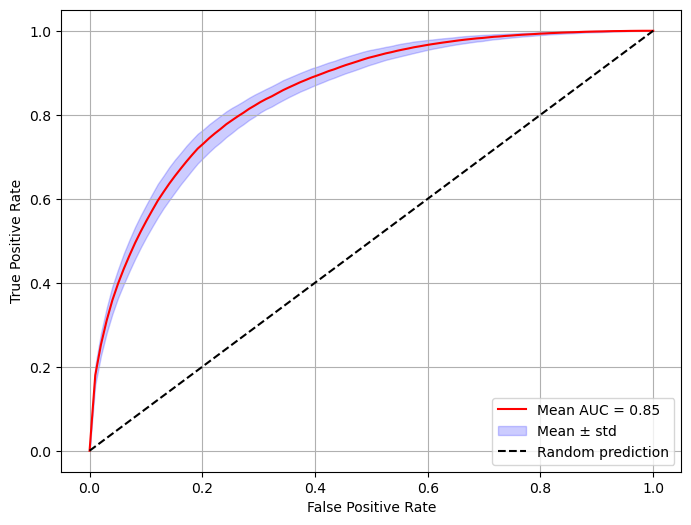

In [26]:
# Plot
save_path = f'../../Plot/{model_version}/ROC'
if not os.path.exists(save_path):
    os.makedirs(save_path)

plt.figure(figsize=(8, 6))

# Mean ROC curve
plt.plot(fpr_points, mean_tpr, color='red', label=f'Mean AUC = {mean_auc:.2f}')

# ±1 std around the mean
plt.fill_between(fpr_points, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='Mean ± std')

# Diagonal line (random prediction)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random prediction')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f'{save_path}/Mean_ROC_Curve.png', bbox_inches='tight')
plt.show()
plt.close()

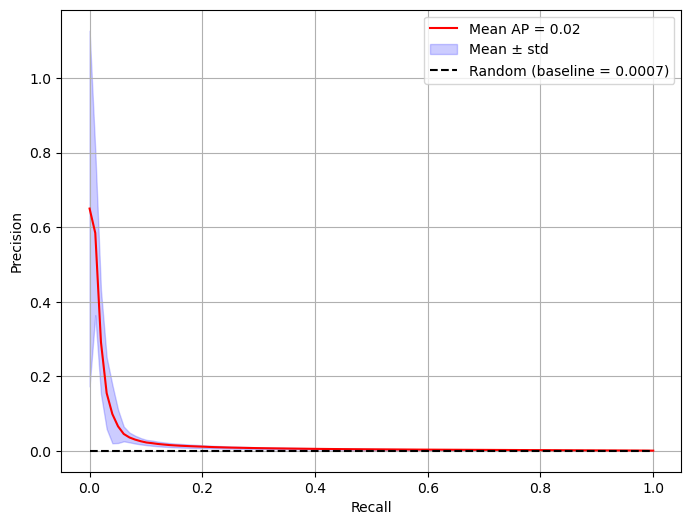

In [27]:
baseline = np.mean(all_y_true)

# Plot
plt.figure(figsize=(8, 6))

# plt.plot(recall_points, mean_precision, color='red', label=f'Mean PR (AP = {mean_ap:.2f} ± {std_ap:.2f})')
plt.plot(recall_points, mean_precision, color='red', label=f'Mean AP = {mean_ap:.2f}')
plt.fill_between(recall_points, mean_precision - std_precision, mean_precision + std_precision, color='blue', alpha=0.2, label='Mean ± std')
plt.hlines(y=baseline, xmin=0, xmax=1, color='black', linestyle='--', label=f'Random (baseline = {baseline:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(f'{save_path}/Mean_PR_Curve.png', bbox_inches='tight')
plt.show()
plt.close()